In [5]:
# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import netCDF4
import h5py
import datetime as dt
from datetime import datetime
import pyproj

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from pyproj import Proj, transform
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import torch

import pickle

%reload_ext autoreload
%autoreload 2

from functions import *
from models import *

## IS2 Observation v. ANN Prediction

In [9]:
sector = "Ross"
laps = 8
c = 1
features, hidden_layers = 128, 2

files = glob.glob(f'D:\\IS2_topo_DL\\data\\Data_{sector}_*.pkl')
xx, yy, inputs, outputs = read_grid_input(files, c)

ann_input, ann_output = make_mlp_input(inputs, outputs, laps = laps)
train_input, val_input, train_output, val_output = train_test_split(ann_input, ann_output, test_size=0.4, random_state=42)

ann_input = torch.tensor(ann_input, dtype=torch.float32)
ann_output = torch.tensor(ann_output, dtype=torch.float32)
train_input = torch.tensor(train_input, dtype=torch.float32)
train_output = torch.tensor(train_output, dtype=torch.float32)
val_input = torch.tensor(val_input, dtype=torch.float32)
val_output = torch.tensor(val_output, dtype=torch.float32)

n_samples, in_channels = val_input.size()
_, out_channels = val_output.size()

net = MLP(in_channels, out_channels, features, hidden_layers)
model_name = f"D:\\IS2_topo_DL\\model\\torch_{sector}_c{c}_lap{laps}_mlp_h{hidden_layers}_f{features}.pth"
device = "cuda"
net = nn.DataParallel(net)
net.load_state_dict(torch.load(model_name, map_location=device))
net = net.to(device)
net.eval()

n_sample = val_input.shape[0]
val_pred = net(val_input.to(device)).to('cpu') #torch.zeros(ann_output.shape)

y_obs = val_output.detach().numpy()
y_prd = val_pred.detach().numpy()


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.60it/s]


Grid files are read!
MLP dataset is ready for lap time 8


Text(0, 0.5, '$\\sigma_f$ predicted by ANN')

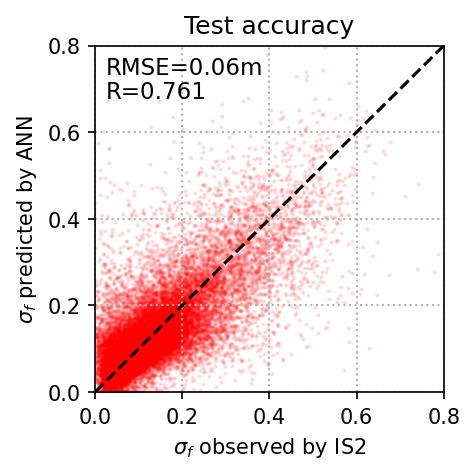

In [13]:
n_sample = val_input.shape[0]
val_pred = net(val_input.to(device)).to('cpu') #torch.zeros(ann_output.shape)

y_obs = val_output.detach().numpy()
y_prd = val_pred.detach().numpy()

plt.figure(figsize = (3,3), dpi = 150)
plt.scatter(y_obs[:], y_prd[:], s = 1, alpha = 0.1, c = "r")
plt.grid(ls = ":", lw = 1)
plt.xlim(0, 0.8)
plt.xticks(np.arange(0, 1.0, 0.2))
plt.ylim(0, 0.8)
plt.yticks(np.arange(0, 1.0, 0.2))
plt.plot([0, 1], [0, 1], ls = "--", c = "k")
rmse = RMSE(y_obs, y_prd)
R = corr(y_obs, y_prd)
plt.annotate(f"R={R:.3f}", xy=(0.03, 0.90), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.annotate(f"RMSE={rmse:.2f}m", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.title("Test accuracy")
plt.xlabel("$\sigma_f$ observed by IS2")
plt.ylabel("$\sigma_f$ predicted by ANN")

Text(0, 0.5, '$\\sigma_f$ predicted by ANN')

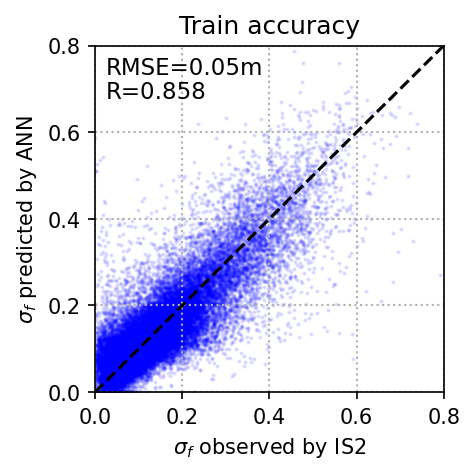

In [14]:
n_sample = train_input.shape[0]
train_pred = net(train_input.to(device)).to('cpu') #torch.zeros(ann_output.shape)

y_obs = train_output.detach().numpy()
y_prd = train_pred.detach().numpy()

plt.figure(figsize = (3,3), dpi = 150)
plt.scatter(y_obs[:], y_prd[:], s = 1, alpha = 0.1, c = "b")
plt.grid(ls = ":", lw = 1)
plt.xlim(0, 0.8)
plt.xticks(np.arange(0, 1.0, 0.2))
plt.ylim(0, 0.8)
plt.yticks(np.arange(0, 1.0, 0.2))
plt.plot([0, 1], [0, 1], ls = "--", c = "k")
rmse = RMSE(y_obs, y_prd)
R = corr(y_obs, y_prd)
plt.annotate(f"R={R:.3f}", xy=(0.03, 0.90), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.annotate(f"RMSE={rmse:.2f}m", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.title("Train accuracy")
plt.xlabel("$\sigma_f$ observed by IS2")
plt.ylabel("$\sigma_f$ predicted by ANN")

In [17]:
outputs.shape

(160, 1, 96, 141)

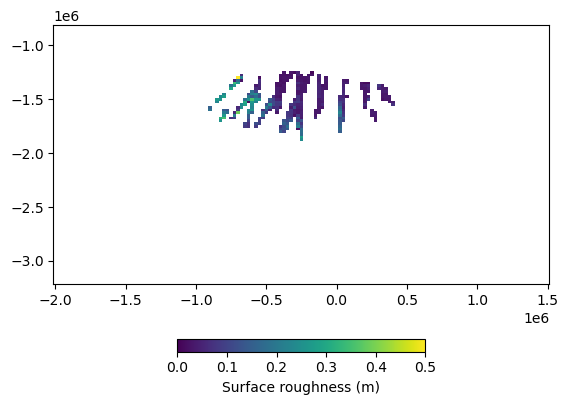

In [26]:
plt.pcolormesh(xx, yy, outputs[0, 0], vmin = 0, vmax = 0.5)
plt.colorbar(shrink = 0.5, label = "Surface roughness (m)", orientation = "horizontal")

## Map grid

In [30]:
d1, d2 = [], []
region = "SH"
data_path = "D:\\PINN\\data"

for year in [2019, 2020, 2021, 2022]:
    ncfile = data_path + f"/{region}/Sea_ice_drift/icemotion_weekly_{region.lower()}_25km_{year}0101_{year}1231_v4.1.nc"
    ds1 = xr.open_dataset(ncfile)
    datetimeindex = ds1.time.astype("datetime64[ns]").values #ds1.indexes['time'].to_datetimeindex() #
    
    for i, d in enumerate(datetimeindex):
        if i >= 12:
            d1.append(pd.to_datetime(d) + dt.timedelta(days = 0))
            d2.append(pd.to_datetime(d) + dt.timedelta(days = 7))

is2_nc = f'D:\\IS2_topo_DL\\Ridges_density_{sector}_{year}.nc'
is2 = xr.open_dataset(is2_nc)

with netCDF4.Dataset(is2_nc, 'r') as nc:
    lat = np.array(nc.variables['lat'])
    lon = np.array(nc.variables['lon'])

mask = (lon <= -150) | (lon > 160)

In [31]:
def draw_ann_map(inputs, outputs, ind, d1, xx, yy, net, device, mask):
    # ANN prediction results
    date = datetime.strftime(d1[ind], "%Y-%m-%d")
    sic = inputs[ind, 2, :, :]
    valid = (sic > 0.8)
    ann_input = make_mlp_grid(inputs[ind-laps:ind+1,:9], laps = laps)
    
    ann_input = torch.tensor(ann_input, dtype=torch.float32)
    row, col = xx.shape
    
    n_samples, in_channels = ann_input.size()
    
    n_sample = ann_input.shape[0]
    ann_pred = net(ann_input.to(device)).to('cpu') #torch.zeros(ann_output.shape)
    
    y_prd = ann_pred.detach().numpy()
    y_grid = y_prd.reshape(row, col)
    y_grid[~(valid & mask)] = np.nan
    
    # Draw map
    fig, ax = plt.subplots(1,2, figsize = (7,3), dpi= 200,
                           subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -70)})
    plt.subplots_adjust(hspace=0.04, wspace=0.04)
    
    ax[0].pcolormesh(xx, yy, outputs[ind, 1], vmin = 0, vmax = 0.5)
    ax[1].pcolormesh(xx, yy, y_grid, vmin = 0, vmax = 0.5)
    
    for i in range(0, 2):
        ax[i].coastlines('10m', linewidth = 0.5)
        ax[i].annotate(date, xy=(0.03, 0.03), xycoords='axes fraction', fontsize=10, ha='left', va='bottom')
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                          xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                          linewidth=0.5, color='k', alpha = 0.5, linestyle='--')
    plt.savefig(f"D:\\IS2_topo_DL\\Figures\\Ross_{date}.jpg", bbox_inches = "tight")
    plt.close()

In [33]:
for ind in np.arange(laps, 40):
    draw_ann_map(inputs, outputs, ind, d1, xx, yy, net, device, mask)

In [34]:
for ind in np.arange(laps, 40) + 40:
    draw_ann_map(inputs, outputs, ind, d1, xx, yy, net, device, mask)

In [35]:
for ind in np.arange(laps, 40) + 80:
    draw_ann_map(inputs, outputs, ind, d1, xx, yy, net, device, mask)

In [36]:
for ind in np.arange(laps, 40) + 120:
    draw_ann_map(inputs, outputs, ind, d1, xx, yy, net, device, mask)

## Draw input & output

In [66]:
vmax = [+20, +20, 1, 280, +20, +20, 30, +0.05, 0.08, 1]
vmin = [-20, -20, 0, 230, -20, -20,  0, -0.05, 0.00, 0]
label = ['$u_{si}$ (km/d)', '$v_{si}$ (km/d)', 'SIC (%)', 'Temp (K)', '$u_{wind}$ (m/s)',
         '$v_{wind}$ (m/s)', 'Wind gust (m/s)', 'Divergence (/day)', 'Shear (/day)']

for ind in np.arange(20, 40) + 80:
    date = datetime.strftime(d1[ind], "%Y-%m-%d")
    
    # Draw map
    fig, ax = plt.subplots(3,3, figsize = (8,7), dpi= 200,
                           subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -70)})
    plt.subplots_adjust(hspace=0.1, wspace=0.04)
    
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            c = i*3 + j
            if vmin[c] < 0:
                cmap = "RdBu"; extend = "both"
            else:
                cmap = "Blues"; extend = "neither"
            cm = ax[i,j].pcolormesh(xx, yy, inputs[ind, c], vmin = vmin[c], vmax = vmax[c], cmap = cmap)
            
            ax[i,j].coastlines('10m', linewidth = 0.5)
            ax[i,j].annotate(date, xy=(0.03, 0.03), xycoords='axes fraction', fontsize=10, ha='left', va='bottom')
            ax[i,j].annotate(label[c], xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
            gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                              xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                              linewidth=0.5, color='k', alpha = 0.5, linestyle='--')
            fig.colorbar(cm, ax = ax[i,j], orientation='horizontal', shrink = 0.5, pad = 0.05, extend = extend)
    plt.savefig(f"D:\\IS2_topo_DL\\Figures\\Ross_inputs_{date}.jpg", bbox_inches = "tight")
    plt.close()